<h2>PARTE EN SUCIO</h2>

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import json
import math
import random
from itertools import tee

In [2]:
def lectura(ruta_archivo: str):
    try:
        # Leer el contenido del archivo JSON
        with open(ruta_archivo, 'r', encoding='utf-8') as archivo:
            datos_json = json.load(archivo)

        # Acceder a todas las entradas de "galactic_object"
        objetos_galacticos = datos_json.get("galactic_object", {})

        if objetos_galacticos:
            map = {}

            # Iterar a través de todas las entradas de "galactic_object"
            for id_objeto, objeto_galactico in objetos_galacticos.items():
                # Acceder e imprimir o utilizar propiedades específicas de cada "galactic_object"
                coordenada = objeto_galactico["coordinate"]
                nombre = objeto_galactico["name"]["key"]
                hyperlane = objeto_galactico.get("hyperlane",[])

                # Verificar si la longitud de hyperlane es mayor que 0, para eliminar vértices anormales
                if len(hyperlane) > 0:
                    # Guardar la información necesaria en el diccionario
                    map[int(id_objeto)] = [nombre, [(i["to"], i["length"]) for i in hyperlane], (coordenada["x"], coordenada["y"])]
            return map
        else:
            raise ValueError("La clave 'galactic_object' no existe en los datos JSON.") 
    
    except Exception as e:
        print(f"Error al leer o analizar el archivo JSON: {e}")



In [3]:
partida = lectura('../output/output1.json')

In [4]:
def test_lectura(diccionario):
    # Imprimir los 3 primeros elementos
    print('Mostrando los tres primeros sistemas de la galaxia:')
    for r in list(diccionario.items())[:3]:
        print(r[0], ": ", r[1])
    # Imprimir puntos suspensivos
    print("...")
    # Imprimir los 3 últimos elementos
    print('Mostrando los tres últimos sistemas de la galaxia:')
    for r in list(diccionario.items())[-3:]:
        print(r[0], ": ", r[1])

In [5]:
def genera_grafo(diccionario) -> nx.Graph:
    diccionarioaux = diccionario.copy()
    diccionarioaux = {clave: diccionarioaux[clave][1] for clave in diccionarioaux}
    grafo = nx.Graph()
    for r in diccionarioaux:
        if len(diccionarioaux[r])>0:
            grafo.add_edges_from((r, k[0]) for k in diccionarioaux[r])
    componentes_conexas = list(nx.connected_components(grafo))

    # Encontrar la componente conexa más grande
    tamanos_componentes = [len(componente) for componente in componentes_conexas]
    indice_componente_a_conservar = tamanos_componentes.index(max(tamanos_componentes))
    componente_a_conservar = list(componentes_conexas[indice_componente_a_conservar])

    # Crear un nuevo grafo con solo la componente conexa más grande
    G_componente_grande = grafo.subgraph(componente_a_conservar).copy()
    for r in diccionario.copy():
        if r not in G_componente_grande:
            diccionario.pop(r)
    return G_componente_grande

In [6]:
mapa = genera_grafo(partida)

In [7]:
def test_genera_grafo(diccionario) -> None:
    grafoaux = genera_grafo(diccionario)
    diccionarioaux = nx.to_dict_of_lists(grafoaux)
    print('Mostrando las conexiones de los tres primeros sistemas de la galaxia:')
    [print(r[0],":",r[1]) for r in sorted(diccionarioaux.items())[:3]]
    print("...")
    print('Mostrando las conexiones de los tres últimos sistemas:')
    [print(r[0],":",r[1]) for r in sorted(diccionarioaux.items())[-3:]]

In [8]:
def adjudica_pesos(grafo, diccionario) -> nx.Graph:
    diccionarioaux = diccionario.copy()
    diccionarioaux = {clave: diccionarioaux[clave][1] for clave in diccionarioaux}
    grafoaux = grafo.copy()
    for origen in diccionarioaux:
        for destino, peso in diccionarioaux[origen]:
            grafoaux[origen][destino]['weight'] = peso
        
    return grafoaux

In [9]:
pesos_mapa = adjudica_pesos(mapa, partida)

In [10]:
def test_adjudica_pesos(grafo, diccionario) -> None:
    grafoaux = adjudica_pesos(grafo, diccionario)
    diccionarioaux = {u: [(v, data['weight']) for v, data in grafoaux[u].items()] for u in grafoaux.nodes()}
    print('Distancias entre los primeros tres sistemas y sus conexiones:')
    [print(r[0],":",r[1]) for r in sorted(diccionarioaux.items())[:3]]
    print("...")
    print('Distancias entre los tres últimos sistemas y sus conexiones:')
    [print(r[0],":",r[1]) for r in sorted(diccionarioaux.items())[-3:]]

In [11]:
def adjudica_posiciones(grafo, diccionario) -> nx.Graph:
    diccionarioaux = diccionario.copy()
    diccionariox = {clave: diccionarioaux[clave][2][0] for clave in diccionarioaux}
    diccionarioy = {clave: diccionarioaux[clave][2][1] for clave in diccionarioaux}
    grafoaux = grafo.copy()
    nx.set_node_attributes(grafoaux, diccionariox, 'x')
    nx.set_node_attributes(grafoaux, diccionarioy, 'y')
    return grafoaux

In [12]:
posiciones_mapa = adjudica_posiciones(pesos_mapa, partida)

In [13]:
def test_adjudica_posiciones(grafo, diccionario) -> None:
    grafoaux = adjudica_posiciones(grafo, diccionario)
    diccionarioaux = {u: (grafoaux.nodes[u]['x'], grafoaux.nodes[u]['y']) for u in grafoaux.nodes()}
    print('Coordenadas de los tres primeros sistemas:')
    [print(u, ":", pos) for u, pos in sorted(diccionarioaux.items())[:3]]
    print("...")
    print('Coordenadas de los tres últimos sistemas:')
    [print(u, ":", pos) for u, pos in sorted(diccionarioaux.items())[-3:]]

In [14]:
def adjudica_etiquetas(grafo, diccionario) -> nx.Graph:
    diccionarioaux = diccionario.copy()
    diccionarioaux = {clave: diccionarioaux[clave][0] for clave in diccionarioaux}
    grafoaux = grafo.copy()
    nx.set_node_attributes(grafoaux, diccionarioaux, 'Label')
    return grafoaux

In [15]:
mapa_completo = adjudica_etiquetas(posiciones_mapa, partida)

In [16]:
def test_adjudica_etiquetas(grafo, diccionario) -> None:
    grafoaux = adjudica_etiquetas(grafo, diccionario)
    diccionarioaux = {u: grafoaux.nodes[u]['Label'] for u in grafoaux.nodes()}
    print('Etiquetas correspondientes a los tres primeros sistemas:')
    [print(u, ":", label) for u, label in sorted(diccionarioaux.items())[:3]]
    print("...")
    print('Etiquetas correspondientes a los tres últimos sistemas:')
    [print(u, ":", label) for u, label in sorted(diccionarioaux.items())[-3:]]

---
<h2><a name="Comercio"></a><strong>4. Estudio del comercio</strong></h2>
<p>Una vez instaurada nuestra capital, debemos de empezar a estudiar uno de los pilares fundamentales para la sostenibilidad de un imperio. Así es, hablamos del <strong>comercio</strong> que circula por el imperio. Un buen estudio no hará que caigamos en la <strong>ruina económica</strong>.</p>
<p>A la hora de hacer un estudio del comercio, sacamos un árbol que represente nuestra región cuya raíz es la capital.</p>

In [17]:
# Crear un grafo
G = Graph()

# Agregar vértices
G.add_vertices(['A', 'B', 'C', 'D', 'E', 'F', 'G'])

# Asignar pesos a los vértices
G.set_vertices({'A': {'weight': 3}, 'B': {'weight': 5}, 'C': {'weight': 2}, 'D': {'weight': 5}, 'E': {'weight': 5}
               , 'F': {'weight': 5}, 'G': {'weight': 5}})

# Agregar aristas
aristas=[('A','B',36),('A','C',12),('B','D',34),('C','E',45),('E','F',48),('E','G',18)]
G.add_edges(aristas)

<p>Cada sistema tiene un valor de comercio que podemos verlo de la siguiente manera:</p>

In [18]:
# Obtener el peso de un vértice específico
peso_A = G.get_vertex('A')['weight']
peso_B = G.get_vertex('B')['weight']
peso_C = G.get_vertex('C')['weight']

# Imprimir resultados
print("Peso del vértice A:", peso_A)
print("Peso del vértice B:", peso_B)
print("Peso del vértice C:", peso_C)

Peso del vértice A: 3
Peso del vértice B: 5
Peso del vértice C: 2


<p>Incluso podemos ver las distancias que hay entre sistemas de la siguiente manera.</p>

In [19]:
G.edges()

[('A', 'B', 36), ('A', 'C', 12), ('B', 'D', 34), ('C', 'E', 45), ('E', 'F', 48), ('E', 'G', 18)]

<p>La función <em>importancia()</em> nos devolverá un diccionario cuyas las claves son los sistemas y sus valores son su importancia en cada uno de ellos.</p>

In [20]:
def importancia(capital, g, nodo=None):
    """
    Calcula la importancia de cada vértice en un arbol.

    Parameters:
        - capital: El vértice desde el cual se calcula la importancia.
        - g: El grafo ponderado.
        - nodo: Opcional, si se especifica, devuelve la importancia solo para ese nodo.

    Returns:
        Un diccionario donde las claves son los vértices y los valores son las medidas de importancia.
        Si se especifica el parámetro 'nodo', devuelve la importancia solo para ese nodo.
    """
    # Inicializar el diccionario de importancia
    importante={}
    
    # Verificar si el grafo es un árbol
    if not g.is_tree():
        raise ValueError("El grafo no es un arbol. Lo has copiado mal listillo. :)")
    elif not es_ponderado_por_vertices(g):
        raise ValueError("El grafo no está ponderado por vertices. Lo has copiado mal listillo. :)")
    else:
        
        # Definir una función interna para calcular la importancia recursivamente
        def calcular_importancia(v):
            """
            Calcula la importancia de cada vértice en un árbol.

            Parameters:
                - v: El vértice actual para el cual se calcula la importancia.

            Returns:
                Un valor que representa la importancia del vértice actual en el árbol.
            """
            # Calcular el peso y la distancia desde la capital hasta el vértice actual
            peso = g.get_vertex(v)['weight']
            distancia = g.shortest_path_length(capital, v, by_weight=True)
            
            # Calcular la importancia para el vértice actual
            valor = peso / distancia
            
            # Sumar la importancia de los hijos y los hijos de los hijos
            suma_hijos = sum(calcular_importancia(hijo) for hijo in children(g,v))
            return valor + suma_hijos
        
        # Calcular la importancia final para cada vértice en el grafo
        for v in g.vertices():
            if not v == capital:
                valor = calcular_importancia(v)
                importante[v] = float(valor)
        
        if nodo==None:
            return importante
        else:
            return importante[nodo]

def children(t,c=None):
    """
    Devuelve una lista que contiene los hijos del nodo dado perteneciente al árbol.

    Parameters:
        - t: El árbol.
        - c: El nodo dado.

    Returns:
        Un diccionario donde las claves son los vértices y los valores la lista de hijos del nodo.
    """
    dic = {}
    lista_visitados = []

    for v in t.vertices():
        lista_hijos = []
        lista_visitados.append(v)
        for vecino in t.neighbors(v):
            if vecino not in lista_visitados:
                lista_hijos.append(vecino)
        dic[v] = lista_hijos
        
    if c==None:
        return dic
    else:
        return dic[c]

def es_ponderado_por_vertices(grafo):
    """
    Verifica si un grafo es ponderado por vertices.

    Parameters:
        - grafo: El grafo a verificar.

    Returns:
        True si todos los vertices tienen un peso, False de lo contrario.
    """
    for v in grafo.vertices():
        datos = grafo.get_vertex(v)
        if not isinstance(datos, dict) or 'weight' not in datos:
            return False
    return True

<p>El funcionamiento de la función consiste en la colocación de la raíz y luego el grafo, y en el caso de que se quiera conocer la importancia de sólo uno de los nodos, se ponde el nodo que quieras conocer. La raíz se excluirá porque siempre será la más importante.</p>

In [21]:
dic =importancia('A',G)
print('Las importancias de cada nodo del árbol:',dic)

dic = importancia('A',G, 'D')
print('La importancia del nodo D:',dic)

Las importancias de cada nodo del árbol: {'B': 0.21031746031746032, 'C': 0.368671679197995, 'D': 0.07142857142857142, 'E': 0.20200501253132833, 'F': 0.047619047619047616, 'G': 0.06666666666666667}
La importancia del nodo D: 0.07142857142857142


### Ejercicio 3:
<p>Utilizando los métodos y atributos disponibles, responder a las siguientes preguntas referentes al grafo G1 definido: ¿Es el grafo G1 un árbol? ¿Qué valores de comercio en cada sistema de G1? ¿Cuál es el sistema más importante después de la capital?</p>

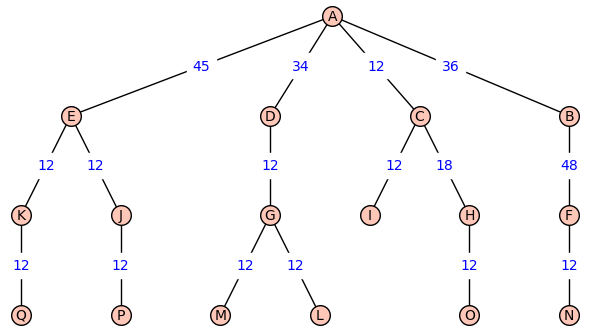

In [22]:
G1 = Graph()
G1.add_vertices(['A', 'B', 'C', 'D', 'E', 'F', 'G','H','I','J','K','L','M','N','O','P','Q'])
G1.set_vertices({'A': {'weight': 5}, 'B': {'weight': 6.23445}, 'C': {'weight': 2.12355}, 'D': {'weight': 6}, 'E': {'weight': 0.2}
               , 'F': {'weight': 9.8123}, 'G': {'weight': 4.12}, 'H': {'weight': 4.21}, 'I': {'weight': 7.2}, 'J': {'weight': 5}
                , 'K': {'weight': 4.53}, 'L': {'weight': 3.234}, 'M': {'weight': 8}, 'N': {'weight': 5.65}, 'O': {'weight': 7.2}
               , 'P': {'weight': 5.2345}, 'Q': {'weight': 8.234663}})
aristas=[('A','B',36),('A','C',12),('A','D',34),('A','E',45),('B','F',48),('C','H',18),('C','I',12),('D','G',12),('E','J',12)
        ,('E','K',12),('F','N',12),('H','O',12),('G','L',12),('G','M',12),('J','P',12),('K','Q',12)]
G1.add_edges(aristas)
G1.plot(layout='tree', edge_labels=True)

<p><strong>SOLUCIÓN</strong></p>
<p>(Se puede borrar estos apartados después, es para mostrar la solución al problema)</p>

In [23]:
G1.is_tree()

True

In [24]:
for v in G1.vertices():
    peso = G1.get_vertex(v)['weight']
    print("Valor de comercio del vértice ",v,":", peso)

Valor de comercio del vértice  A : 5
Valor de comercio del vértice  B : 6.23445000000000
Valor de comercio del vértice  C : 2.12355000000000
Valor de comercio del vértice  D : 6
Valor de comercio del vértice  E : 0.200000000000000
Valor de comercio del vértice  F : 9.81230000000000
Valor de comercio del vértice  G : 4.12000000000000
Valor de comercio del vértice  H : 4.21000000000000
Valor de comercio del vértice  I : 7.20000000000000
Valor de comercio del vértice  J : 5
Valor de comercio del vértice  K : 4.53000000000000
Valor de comercio del vértice  L : 3.23400000000000
Valor de comercio del vértice  M : 8
Valor de comercio del vértice  N : 5.65000000000000
Valor de comercio del vértice  O : 7.20000000000000
Valor de comercio del vértice  P : 5.23450000000000
Valor de comercio del vértice  Q : 8.23466300000000


In [25]:
dic =importancia('A',G1)
valor_max = max(dic.values())
importantes = [clave for clave, valor in dic.items() if valor == valor_max]
print(importantes)

['C']
